# Interest rates data preparation for prediction

In [156]:
import numpy as np
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go
import math

from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.dates import YearLocator, DateFormatter

import scipy.stats.distributions as dist
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
from scipy.stats import pearsonr

from dask import dataframe as dd
import time

from generic_functions import check_duplicates, check_missing_values, value_counts_to_dataframe, pivot_dim2

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pca_functions import plot_variance, make_mi_scores

# balancing dataset
from imblearn.over_sampling import SMOTE

from sklearn import model_selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.pipeline import Pipeline

from scipy.stats import reciprocal, uniform

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

os.getcwd()

'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/input'

# Data loading

<b>External data. Federal interest rates:</b>

Loans interest rates consist of various parts. One of them is federal interest rates. We will include federal interset rates on monthly basis to the loans by issued dates. 

In [37]:
path_fed_int_rates = '/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/data/FEDFUNDS.csv'
df_int_rate = pd.read_csv(path_fed_int_rates)
df_int_rate['year_month'] = df_int_rate.DATE.apply(lambda x: x[:-3])
df_int_rate = df_int_rate.rename(columns={"FEDFUNDS":"fed_int_rates"})
df_int_rate.head(2)

,DATE,fed_int_rates,year_month
0,2007-01-01,5.25,2007-01
1,2007-02-01,5.26,2007-02


<b>Lending club loans data:</b>

In [51]:
import glob
os.chdir('/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/input')

In [99]:
files_ = [f for f in glob.glob("*.csv")]
files_

['lending_data_2018.csv',
 'lending_data_2009.csv',
 'lending_data_2008.csv',
 'lending_data_2011.csv',
 'lending_data_2010.csv',
 'lending_data_2012.csv',
 'lending_data_2007.csv',
 'lending_data_2013.csv',
 'lending_data_2017.csv',
 'lending_data_2016.csv',
 'lending_data_2014.csv',
 'lending_data_2015.csv']

In [100]:
years_ = ['2017']

In [106]:
matching = []
lst = []
j = 1
for i in years_:
    matching_stg = [s for s in files_ if i in s][0]
    matching.append(matching_stg)
    
for url in matching:  
    path_ = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/input/{url}'
    data = pd.read_csv(path_)
    lst.append(data)                        
df_ = pd.concat(lst)

df_.info()
print(df_.year.unique())
df_ = df_.drop(columns = ['index','level_0','id','member_id'])

df_ = df_[df_.emp_length.isna() == False].reset_index()
df_ = df_[df_.emp_title.isna() == False].reset_index()
df_ = df_.drop(columns = ['index','level_0'])

df_.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443579 entries, 0 to 443578
Columns: 154 entries, level_0 to year
dtypes: float64(114), int64(4), object(36)
memory usage: 521.2+ MB
[2017]


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,year
0,12000.0,12000.0,12000.0,36 months,7.97,375.88,A,A5,associate,10+ years,OWN,42000.0,Source Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,923xx,CA,27.74,0.0,Jun-1996,715.0,719.0,0.0,NaN,80.0,9.0,1.0,11457.0,37.0,16.0,w,6688.31,6688.31,6397.93,6397.93,5311.69,1086.24,0.0,0.0,0.0,Mar-2019,375.88,Apr-2019,Mar-2019,729.0,725.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,30502.0,1.0,2.0,1.0,3.0,8.0,19045.0,73.0,2.0,4.0,7117.0,53.0,31000.0,1.0,1.0,2.0,7.0,3389.0,7144.0,53.9,0.0,0.0,131.0,255.0,1.0,1.0,0.0,14.0,NaN,8.0,NaN,0.0,2.0,6.0,2.0,2.0,7.0,7.0,9.0,6.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,2017
1,16000.0,16000.0,16000.0,36 months,7.97,501.17,A,A5,Senior Investigator,5 years,RENT,79077.0,Not Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,223xx,VA,15.94,0.0,Jun-2000,700.0,704.0,0.0,38.0,NaN,12.0,0.0,16217.0,57.7,20.0,w,8917.81,8917.81,8511.19,8511.19,7082.19,1429.00,0.0,0.0,0.0,Feb-2019,501.17,Apr-2019,Mar-2019,689.0,685.0,0.0,63.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,128572.0,0.0,1.0,0.0,0.0,38.0,112355.0,NaN,0.0,0.0,2959.0,58.0,28100.0,0.0,0.0,0.0,0.0,10714.0,336.0,90.9,0.0,0.0,145.0,207.0,32.0,32.0,0.0,206.0,NaN,NaN,38.0,2.0,2.0,11.0,2.0,2.0,9.0,11.0,11.0,11.0,12.0,0.0,0.0,0.0,0.0,78.9,100.0,0.0,0.0,125018.0,128572.0,3700.0,96918.0,NaN,NaN,NaN,NaN,

In [107]:
months_map = {'Dec': '12', 
              'Nov': '11', 
              'Oct': '10',
              'Sep': '09', 
              'Aug': '08', 
              'Jul': '07', 
              'Jun': '06', 
              'May': '05', 
              'Apr': '04',
              'Mar': '03', 
              'Feb': '02', 
              'Jan': '01'
             }

df_['year_month'] = df_.issue_d.apply(lambda x: str(x).split('-')[1]+'-'+months_map[str(x).split('-')[0]])
df_[['issue_d','year_month']].head(5)

,issue_d,year_month
0,Sep-2017,2017-09
1,Sep-2017,2017-09
2,Sep-2017,2017-09
3,Sep-2017,2017-09
4,Sep-2017,2017-09


In [108]:
df_stg = pd.merge(df_,df_int_rate,how='left',on='year_month')
df_stg[['fed_int_rates','int_rate']].head(5)

,fed_int_rates,int_rate
0,1.15,7.97
1,1.15,7.97
2,1.15,7.21
3,1.15,11.99
4,1.15,15.05


# Data adjustments

In [109]:
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'Charged Off': 0,
    'Default': 0,
    'In Grace Period': 0,
    'Late (31-120 days)': 0,
    'Late (16-30 days)': 0 
    }
df_stg['IsLoanAccepted'] = df_stg.loan_status.apply(lambda x: loan_status_mapping[x])

In [111]:
df_stg['emp_title_mod'] = df_stg.emp_title.apply(lambda x: str(x).lower())

df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('nurse') == True, 'nurse', df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('teacher') == True, 'teacher',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('driver') == True, 'driver',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('analyst') == True, 'analyst',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('engineer') == True, 'engineer',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('mechanic') == True, 'mechanic',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('accountant') == True, 'accountant',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('attorney') == True, 'attorney',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('sales') == True, 'sales',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('police') == True, 'police',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('supervisor') == True, 'supervisor',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('owner') == True, 'owner',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('manager') == True, 'manager',df_stg.emp_title_mod)
df_stg['emp_title_mod'] = np.where(df_stg['emp_title_mod'].str.contains('director') == True, 'director',df_stg.emp_title_mod)

In [112]:
emp_len_map = {
               '< 1 year': 0, 
               '1 year': 1, 
               '2 years': 2,
               '3 years': 3,
               '4 years': 4, 
               '5 years': 5,
               '6 years': 6,
               '7 years': 7, 
               '8 years': 8, 
               '9 years': 9, 
               '10+ years': 10 
               }

df_stg['emp_length'] = df_stg.emp_length.apply(lambda x: emp_len_map[x])
df_stg.emp_length.unique()

array([10,  5,  0,  9,  1,  3,  7,  2,  8,  4,  6])

In [113]:
df_stg['home_ownership'] = df_stg.home_ownership.apply(lambda x: x.replace(' ',''))
df_stg['verification_status'] = df_stg.verification_status.apply(lambda x: x.replace(' ',''))
df_stg['purpose'] = df_stg.purpose.apply(lambda x: x.replace(' ',''))
df_stg['application_type'] = df_stg.application_type.apply(lambda x: x.replace(' ',''))
df_stg['loan_status'] = df_stg.loan_status.apply(lambda x: x.replace(' ','')) 

# Interest rates overview

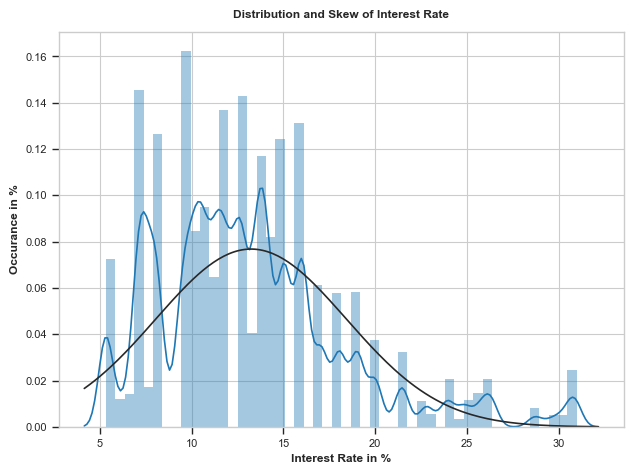

In [114]:
from scipy.stats import norm
sns.distplot(df_stg['int_rate'], fit=norm)
plt.title("Distribution and Skew of Interest Rate")
plt.xlabel("Interest Rate in %")
plt.ylabel("Occurance in %")
plt.show()

Show how data is distributed across its different values.

The extended tail forward gives a clear sign of a positive skew in our interest rate. This means that there are much more lower values than there are high values. Possible solutions we could apply include the square root and log functions

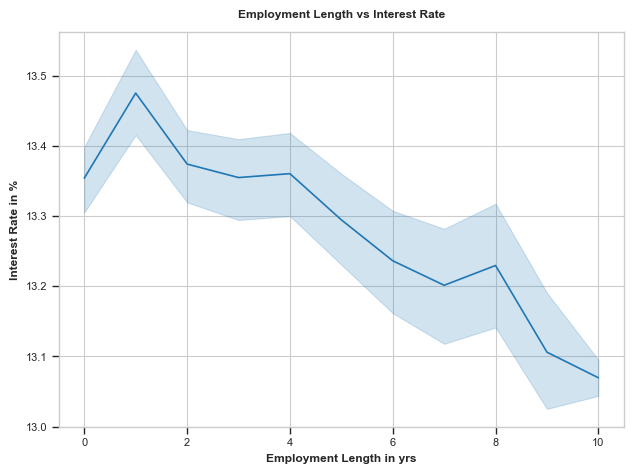

In [115]:
sns.lineplot(x=df_stg['emp_length'], y=df_stg['int_rate'])
plt.title("Employment Length vs Interest Rate")
plt.xlabel("Employment Length in yrs")
plt.ylabel("Interest Rate in %")
plt.show()



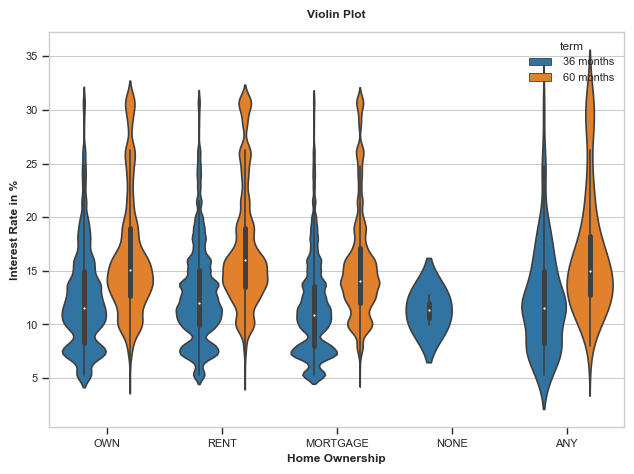

In [116]:
sns.violinplot(x="home_ownership", y="int_rate", data=df_stg, hue="term")
plt.title("Violin Plot")
plt.xlabel("Home Ownership")
plt.ylabel("Interest Rate in %")
plt.show()

<Axes: >

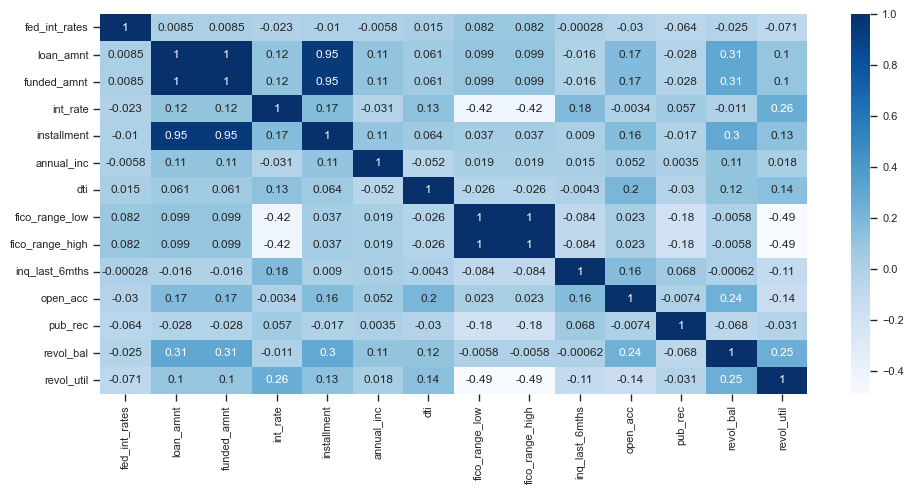

In [117]:
num_columns = ['fed_int_rates','loan_amnt','funded_amnt','int_rate','installment','annual_inc',
'dti','fico_range_low','fico_range_high','inq_last_6mths',
'open_acc','pub_rec','revol_bal','revol_util']

plt.figure(figsize = (10,5))

sns.set_context("paper", font_scale=0.9) 

sns.heatmap(df_stg[num_columns].corr(), 
        annot=True,
        cmap="Blues")

# Training and Test samples split

In [257]:
features = ['fed_int_rates','loan_amnt','funded_amnt','loan_status','IsLoanAccepted',
           'installment','annual_inc','dti','fico_range_low',
           'fico_range_high','inq_last_6mths',
           'open_acc','pub_rec','revol_bal','revol_util',
            'term','grade','sub_grade','emp_length',#'emp_title_mod',
           'home_ownership','verification_status',
           'purpose','addr_state','application_type'
           ]

target = ['int_rate']

In [258]:
X , y = df_stg[features],df_stg[target]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [259]:
print('Training sample', x_train.shape)
print('Test sample', x_test.shape)

Training sample (328893, 24)
Test sample (82224, 24)


# Features engineering

## Check & handling missing values

<b>Training dataset:</b>

In [260]:
check_missing_values(x_train)
print(x_train.isna().sum())

x_train['dti'] = x_train['dti'].fillna(round(x_train['dti'].median(),2))
x_train['revol_util'] = x_train['revol_util'].fillna(round(x_train['revol_util'].median(),2))

Table has missing values
fed_int_rates            0
loan_amnt                0
funded_amnt              0
loan_status              0
IsLoanAccepted           0
installment              0
annual_inc               0
dti                     23
fico_range_low           0
fico_range_high          0
inq_last_6mths           0
open_acc                 0
pub_rec                  0
revol_bal                0
revol_util             316
term                     0
grade                    0
sub_grade                0
emp_length               0
home_ownership           0
verification_status      0
purpose                  0
addr_state               0
application_type         0
dtype: int64


<b>Test dataset:<b>

In [261]:
check_missing_values(x_test)
print(x_test.isna().sum())

x_test['dti'] = x_test['dti'].fillna(round(x_test['dti'].median(),2))
x_test['revol_util'] = x_test['revol_util'].fillna(round(x_test['revol_util'].median(),2))

Table has missing values
fed_int_rates           0
loan_amnt               0
funded_amnt             0
loan_status             0
IsLoanAccepted          0
installment             0
annual_inc              0
dti                     8
fico_range_low          0
fico_range_high         0
inq_last_6mths          0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util             82
term                    0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
verification_status     0
purpose                 0
addr_state              0
application_type        0
dtype: int64


## Categorical values preparation

<b>Categorical variables distribution per adjustment approach</b>:

In [262]:
x_train['home_ownership_ord'] = x_train['home_ownership']
x_train['verification_status_ord'] = x_train['verification_status']
x_train['purpose_ord'] = x_train['purpose']
x_train['addr_state_ord'] = x_train['addr_state']
x_train['application_type_ord'] = x_train['application_type']

x_test['home_ownership_ord'] = x_test['home_ownership']
x_test['verification_status_ord'] = x_test['verification_status']
x_test['purpose_ord'] = x_test['purpose']
x_test['addr_state_ord'] = x_test['addr_state']
x_test['application_type_ord'] = x_test['application_type']

In [264]:
#'emp_title_mod', 'purpose_ord'
object_cols_ordinal = ['term', 'grade', 'sub_grade','loan_status',
                      'home_ownership_ord','verification_status_ord',
                      'addr_state_ord','application_type_ord'
                      ]

object_cols_category = ['home_ownership', 'verification_status', 
                        'purpose', 'addr_state', 'application_type']

### Ordinal encoder

In [265]:
print(x_train.shape)
print(x_test.shape)

(328893, 29)
(82224, 29)


In [266]:
ordinal_encoder = OrdinalEncoder()

x_train[object_cols_ordinal] = ordinal_encoder.fit_transform(x_train[object_cols_ordinal])
x_train[object_cols_ordinal].head(3)

,term,grade,sub_grade,loan_status,home_ownership_ord,verification_status_ord,addr_state_ord,application_type_ord
120066,0.0,3.0,18.0,1.0,1.0,1.0,24.0,0.0
280674,0.0,1.0,9.0,1.0,4.0,1.0,19.0,0.0
359822,0.0,2.0,11.0,1.0,1.0,1.0,33.0,0.0


In [267]:
x_test[object_cols_ordinal] = ordinal_encoder.transform(x_test[object_cols_ordinal])
x_test[object_cols_ordinal].head(3)

,term,grade,sub_grade,loan_status,home_ownership_ord,verification_status_ord,addr_state_ord,application_type_ord
333216,0.0,2.0,13.0,1.0,4.0,0.0,33.0,0.0
156994,0.0,2.0,12.0,3.0,3.0,0.0,37.0,0.0
163804,0.0,0.0,3.0,1.0,4.0,1.0,13.0,0.0


In [268]:
dim_purpose = pd.DataFrame(df_stg.purpose.unique(),columns=['purpose']).reset_index()
dim_purpose = dim_purpose.rename(columns={'index':'purpose_mod','purpose':'purpose_ord'})
dim_purpose

,purpose_mod,purpose_ord
0,0,debt_consolidation
1,1,credit_card
2,2,house
3,3,home_improvement
4,4,moving
5,5,other
6,6,major_purchase
7,7,medical
8,8,small_business
9,9,vacation


In [269]:
x_train = pd.merge(x_train,dim_purpose,how='left',on='purpose_ord').drop(columns=['purpose_ord'])
x_train.head(4)

x_test = pd.merge(x_test,dim_purpose,how='left',on='purpose_ord').drop(columns=['purpose_ord'])
x_test.head(4)

,fed_int_rates,loan_amnt,funded_amnt,loan_status,IsLoanAccepted,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,addr_state,application_type,home_ownership_ord,verification_status_ord,addr_state_ord,application_type_ord,purpose_mod
0,1.30,4000.0,4000.0,1.0,1,138.76,28000.0,26.02,705.0,709.0,0.0,14.0,0.0,13661.0,39.5,0.0,2.0,13.0,9,RENT,NotVerified,medical,NY,Individual,4.0,0.0,33.0,0.0,7
1,0.91,11350.0,11350.0,3.0,1,388.36,36000.0,20.03,760.0,764.0,1.0,4.0,0.0,1817.0,15.5,0.0,2.0,12.0,10,OWN,NotVerified,debt_consolidation,PA,Individual,3.0,0.0,37.0,0.0,0
2,0.91,8000.0,8000.0,1.0,1,248.30,81000.0,10.49,720.0,724.0,1.0,11.0,0.0,8664.0,27.6,0.0,0.0,3.0,6,RENT,SourceVerified,debt_consolidation,IL,Individual,4.0,1.0,13.0,0.0,0
3,1.16,14400.0,14400.0,3.0,1,433.66,65000.0,15.18,725.0,729.0,0.0,12.0,1.0,13670.0,32.1,0.0,0.0,0.0,10,MORTGAGE,NotVerified,debt_consolidation,IN,Individual,1.0,0.0,14.0,0.0,0


### One-Hot Encoding

In [270]:
OH_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

labels = list(x_train.home_ownership.unique())
ohe = ColumnTransformer(
    transformers=[("ohe", OH_encoder, object_cols_category),],
    remainder="passthrough",
)
ohe.set_output(transform="pandas")

OH_cols_train = pd.DataFrame(ohe.fit_transform(x_train[object_cols_category]))
OH_cols_test = pd.DataFrame(ohe.transform(x_test[object_cols_category]))

# # Remove categorical columns (will replace with one-hot encoding)
num_x_train = x_train.drop(object_cols_category, axis=1)
num_x_test = x_test.drop(object_cols_category, axis=1)

# # Add one-hot encoded columns to numerical features
x_train = pd.concat([num_x_train, OH_cols_train], axis=1)
x_test = pd.concat([num_x_test, OH_cols_test], axis=1)

In [271]:
x_train.head(3)

,fed_int_rates,loan_amnt,funded_amnt,loan_status,IsLoanAccepted,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,term,grade,sub_grade,emp_length,home_ownership_ord,verification_status_ord,addr_state_ord,application_type_ord,purpose_mod,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_NONE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_NotVerified,ohe__verification_status_SourceVerified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_educational,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY,ohe__application_type_Individual,ohe__application_type_JointApp
0,1.04,24000.0,24000.0,1.0,1,891.93,110000.0,24.63,680.0,684.0,0.0,12.0,1.0,19982.0,69.9,0.0,3.0,18.0,2,1.0,1.0,24.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.65,15000.0,15000.0,1.0,1,494.57,120000.0,17.98,665.0,669.0,0.0,13.0,0.0,15210.0,80.5,0.0,1.0,9.0,7,4.0,1.0,19.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.16,12000.0,12000.0,1.0,1,407.75,160000.0,25.06,700.0,704.0,0.0,21.0,0.0,42650.0,58.6,0.0,2.0,11.0,10,1.0,1.0,33.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [272]:
x_test.head(3)

,fed_int_rates,loan_amnt,funded_amnt,loan_status,IsLoanAccepted,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,term,grade,sub_grade,emp_length,home_ownership_ord,verification_status_ord,addr_state_ord,application_type_ord,purpose_mod,ohe__home_ownership_ANY,ohe__home_ownership_MORTGAGE,ohe__home_ownership_NONE,ohe__home_ownership_OWN,ohe__home_ownership_RENT,ohe__verification_status_NotVerified,ohe__verification_status_SourceVerified,ohe__verification_status_Verified,ohe__purpose_car,ohe__purpose_credit_card,ohe__purpose_debt_consolidation,ohe__purpose_educational,ohe__purpose_home_improvement,ohe__purpose_house,ohe__purpose_major_purchase,ohe__purpose_medical,ohe__purpose_moving,ohe__purpose_other,ohe__purpose_renewable_energy,ohe__purpose_small_business,ohe__purpose_vacation,ohe__addr_state_AK,ohe__addr_state_AL,ohe__addr_state_AR,ohe__addr_state_AZ,ohe__addr_state_CA,ohe__addr_state_CO,ohe__addr_state_CT,ohe__addr_state_DC,ohe__addr_state_DE,ohe__addr_state_FL,ohe__addr_state_GA,ohe__addr_state_HI,ohe__addr_state_ID,ohe__addr_state_IL,ohe__addr_state_IN,ohe__addr_state_KS,ohe__addr_state_KY,ohe__addr_state_LA,ohe__addr_state_MA,ohe__addr_state_MD,ohe__addr_state_ME,ohe__addr_state_MI,ohe__addr_state_MN,ohe__addr_state_MO,ohe__addr_state_MS,ohe__addr_state_MT,ohe__addr_state_NC,ohe__addr_state_ND,ohe__addr_state_NE,ohe__addr_state_NH,ohe__addr_state_NJ,ohe__addr_state_NM,ohe__addr_state_NV,ohe__addr_state_NY,ohe__addr_state_OH,ohe__addr_state_OK,ohe__addr_state_OR,ohe__addr_state_PA,ohe__addr_state_RI,ohe__addr_state_SC,ohe__addr_state_SD,ohe__addr_state_TN,ohe__addr_state_TX,ohe__addr_state_UT,ohe__addr_state_VA,ohe__addr_state_VT,ohe__addr_state_WA,ohe__addr_state_WI,ohe__addr_state_WV,ohe__addr_state_WY,ohe__application_type_Individual,ohe__application_type_JointApp
0,1.30,4000.0,4000.0,1.0,1,138.76,28000.0,26.02,705.0,709.0,0.0,14.0,0.0,13661.0,39.5,0.0,2.0,13.0,9,4.0,0.0,33.0,0.0,7,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.91,11350.0,11350.0,3.0,1,388.36,36000.0,20.03,760.0,764.0,1.0,4.0,0.0,1817.0,15.5,0.0,2.0,12.0,10,3.0,0.0,37.0,0.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.91,8000.0,8000.0,1.0,1,248.30,81000.0,10.49,720.0,724.0,1.0,11.0,0.0,8664.0,27.6,0.0,0.0,3.0,6,4.0,1.0,13.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [273]:
path_train = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_int_rates/x_train.csv'
path_test = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_int_rates/x_test.csv'
x_train.to_csv(path_train,index=False)
x_test.to_csv(path_test,index=False)

path_ytrain = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_int_rates/y_train.csv'
path_ytest = f'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M3S3/output_int_rates/y_test.csv'
y_train.to_csv(path_ytrain,index=False)
y_test.to_csv(path_ytest,index=False)